In [149]:
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import json

from Clustering import BirchCluster

def NewsBiasClusteringFromMetrics(metrics, threshold=0.32, n_clusters=None):    
    # Cluster metrics
    labels = BirchCluster(metrics, threshold=threshold, n_clusters=n_clusters)
    print(Counter(labels))

    # Reduce Data Dimensions
    data = pd.DataFrame(metrics,columns=['sentiment','quoteBased','sensationalized','mudslinging','spin','informal'])
    scalar = StandardScaler()
    scaled_data = pd.DataFrame(scalar.fit_transform(data),columns=['sentiment','quoteBased','sensationalized','mudslinging','spin','informal']) #scaling the data
    #sns.heatmap(scaled_data.corr())
    pca = PCA(n_components = 2)
    pca.fit(scaled_data)
    data_pca = pca.transform(scaled_data)
    data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2'])
    #sns.heatmap(data_pca.corr())

    # Output Clustered Graph
    for i in range(len(Counter(labels))):
        pc1 = []
        pc2 = []
        for j in range(len(labels)):
            if labels[j] == i:
                pc1.append(data_pca.iloc[j]['PC1'])
                pc2.append(data_pca.iloc[j]['PC2'])
        plt.scatter(pc1,pc2,s=5)
    plt.xlim(-8, 10)
    plt.ylim(-5, 15)
    #plt.show()

    # Get Dominant Metrics For Each Label
    data['label'] = labels

    means = data.groupby(['label']).mean()
    standardDeviations = data.groupby(['label']).std()

    dominantMetrics = []
    for i in range(len(Counter(labels))):
        dominant = []
        for col in means.columns:
            mean = means[col].mean()
            std = means[col].std()
            outliers = means[col][(means[col] < mean-std) | (means[col] > mean+std)]
            try:
                dominant.append([col, round(outliers[i],1)])
            except:
                continue
        if len(dominant) == 0:
            dominantStd = list(standardDeviations.iloc[i])
            dominantStd.sort()
            for col in standardDeviations.columns:
                if standardDeviations.iloc[i][col] == dominantStd[0]:
                    dominant.append([col, round(means.iloc[i][col],1)])
        dominantMetrics.append(dominant)
    
    return labels, data_pca, dominantMetrics

In [4]:
print('Loading File')
file = open('rust-articles-backup-metrics.json', encoding='utf8')
articles = pd.DataFrame.from_dict(json.load(file))
print('File Loaded')

Loading File
File Loaded


Counter({0: 431, 2: 338, 1: 153, 3: 76, 4: 2})


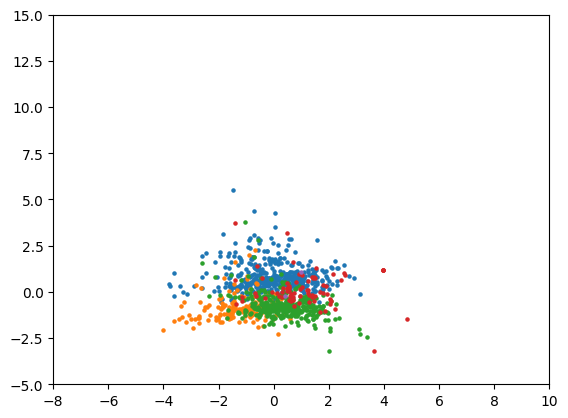

In [154]:
small_articles = articles[:1000]
metrics = []
for i in range(len(small_articles)):
    sentiment = small_articles.iloc[i]['sentiment']
    quoteBased = small_articles.iloc[i]['quoteBased']
    sensationalized = small_articles.iloc[i]['sensationalized']
    mudslinging = small_articles.iloc[i]['mudslinging']
    spin = small_articles.iloc[i]['spin']
    informal = small_articles.iloc[i]['informal']
    metrics.append([sentiment, quoteBased, sensationalized, mudslinging, spin, informal])
labels, data_pca, dominantMetrics = NewsBiasClusteringFromMetrics(metrics)

In [160]:
a = pd.DataFrame()
a['a'] =dominantMetrics
a

,a
0,"[[sentiment, 0.0], [sensationalized, 0.0]]"
1,"[[quoteBased, 0.6], [informal, 0.4]]"
2,"[[sentiment, 1.0]]"
3,"[[sensationalized, 0.0]]"
4,"[[sensationalized, 0.0], [mudslinging, 0.0], [..."
